# Домашнее задание «Функции потерь и оптимизация»
## Реализация логистической регресии

Для собственной реализации логистической регрессии в качестве функции потерь используем бинарную кросс-энтропию.

Для оптимизации поиска минимума функции потерь используем стохастический градиентный спуск (SGD)

Алгоритм будет иметь встроенный аналог SandardScaler

In [ ]:
import numpy as np
import pandas as pd
from numpy.typing import ArrayLike

In [ ]:
class CustomLogisticRegression:
    
    def __init__(self, bs:int, epochs:int, lr:float) -> None:
        '''
        Создает экземпляр модели логистической регресси с указанными параметрами
        
        Параметры
        ---------
        bs : размер батча для SDG
        epochs: количество итераций
        lr : learning rate
        '''
        self._bs = bs
        self._epochs = epochs
        self._lr = lr
    
    def _sigmoid(self, z:ArrayLike) -> ArrayLike:
        '''
        реализация функции сигмоида
        '''
        return 1.0/(1 + np.exp(-z))
        
    def _loss(self, y:float, y_p:float) -> float:
        '''
        Возвращает значение функции потерь
        
        Парметры
        --------
        y : истиное значение класса
        y_p : предсказаное значение класса
        '''
        return -np.mean(y*(np.log(y_p)) - (1-y)*np.log(1-y_p))
    
    def _derivatives(self, X:ArrayLike, y:int, y_p:int) -> (float, float):
        '''
        Возвращает производные для коэффициентов tetha0(b) и tetha1(w)
        
        Параметры
        ---------
        X : массив признаков
        y : истинное значение класса
        y_p : предсказанное значение класса
        
        Возвращает
        ----------
        dw : производная для tetha1
        db : производная для tetha0
        '''
        m = X.shape[0]
        dw = (1/m)*np.dot(X.T, (y_p - y))
        db = (1/m)*np.sum((y_p - y))
        return dw, db
    
    def _scale(self, X: ArrayLike) -> ArrayLike:
        '''
        Аналог StandardScaler
        
        Параметры
        ---------
        X : массив признаков
        
        Возвращает
        ----------
        X : преобразованый массив признаков
        '''
        m, n = X.shape
        for i in range(n):
            X = (X - X.mean(axis=0))/X.std(axis=0)
        return X
        
    def fit(self, X:ArrayLike, y:ArrayLike) -> None:
        '''
        Обучает экземпляр модели
        
        Параметры
        ---------
        X : массив признаков
        y : массив истинных значений класса
        '''
        m, n = X.shape
        
        # устанавливаем начальные значения w и b
        w = np.zeros((n,1))
        b = 0
        
        # решейпим y
        try:
            y = y.reshape(m,1)
        except AttributeError:
            y = y.to_numpy().reshape(m,1)
        
        # нормализуем пространство признаков
        x = self._scale(X)
        
        losses = []
        for epoch in range(self._epochs):
            ## Определяем батчи для SGD
            for i in range((m-1)//self._bs +1):
                start_iter = i*self._bs
                stop_iter = start_iter + self._bs
                xb = X[start_iter:stop_iter]
                yb = y[start_iter:stop_iter]
                
                # Вычисляем вероятность значения класса
                y_p = self._sigmoid(np.dot(xb, w) + b)
                
                # Получаем значения производных для tetha0 и tetha1
                dw, db = self._derivatives(xb, yb, y_p)
                
                # Обновляем значения tetha0 и tetha1
                w = w - self._lr*dw
                b = b - self._lr*db
                
            # Вычисляем loss и добавляем к списку
            y_p = self._sigmoid(np.dot(X, w) + b)
            l = self._loss(y, y_p)
            losses.append(l)
        self.losses = losses
        self.w = w
        self.b = b
    
    def predict(self, X:ArrayLike) -> ArrayLike:
        '''
        Возвращает вычисленный массив классов
        
        Параметры
        ---------
        X : массив признаков
        
        Возвращает
        ----------
        y_p : массив классов
        '''
        
        preds = [p[0] for p in self.predict_proba(X)]
        pred_class = []
        # 1 если y_p >= 0.5
        # 0 если y_p < 0.5
        pred_class = [1 if i > 0.5 else 0 for i in preds]
        return np.array(pred_class)
    
    def predict_proba(self, X:ArrayLike) -> ArrayLike:
        '''
        Возвращает вероятность принадлежности к тому или иному классу
        
        Параметры
        ---------
        X : массив признаков
        
        Возвращает
        ----------
        T : массив вероятностей принадлежности к тому или иному классу
        '''
        
        # нормализуем пространство признаков
        x = self._scale(X)
        preds = self._sigmoid(np.dot(x, self.w) + self.b)
        pred_proba = []
        pred_proba = [[p, 1-p] for p in preds]
        return pred_proba
    
    def score(self, X:ArrayLike, y:ArrayLike) -> float:
        '''
        Возвращает среднюю точность (accuracy) модели:
        
        Параметры
        ---------
        X: массив признаков
        y : массив истинных классов
        
        
        Возвращает
        ----------
        score: средняя точность модели
        '''
        y_p = self.predict(X)
        score = np.sum(y == y_p) / len(y)
        return score

### Проверка работы модели
Загрузим датасет iris

In [ ]:
from sklearn.datasets import load_iris

In [ ]:
dataset = load_iris()

In [ ]:
df = pd.DataFrame(data= np.c_[dataset['data'], dataset['target']],
                     columns= dataset['feature_names'] + ['target'])

In [ ]:
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2.0
146,6.3,2.5,5.0,1.9,2.0
147,6.5,3.0,5.2,2.0,2.0
148,6.2,3.4,5.4,2.3,2.0


Отфильтруем класс Setosa. Оставшие метки классов преобразуем к [0,1]

In [ ]:
df_filtered = df[df["target"] != 0]

In [ ]:
df_filtered['target'].replace(to_replace={1:0, 2:1}, inplace=True)

/home/anonymous/Projects/lab/lib/python3.10/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [ ]:
df_filtered

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
50,7.0,3.2,4.7,1.4,0.0
51,6.4,3.2,4.5,1.5,0.0
52,6.9,3.1,4.9,1.5,0.0
53,5.5,2.3,4.0,1.3,0.0
54,6.5,2.8,4.6,1.5,0.0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,1.0
146,6.3,2.5,5.0,1.9,1.0
147,6.5,3.0,5.2,2.0,1.0
148,6.2,3.4,5.4,2.3,1.0


Матрица корреляции признаков

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

/tmp/ipykernel_338951/1496439667.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),


<AxesSubplot:>

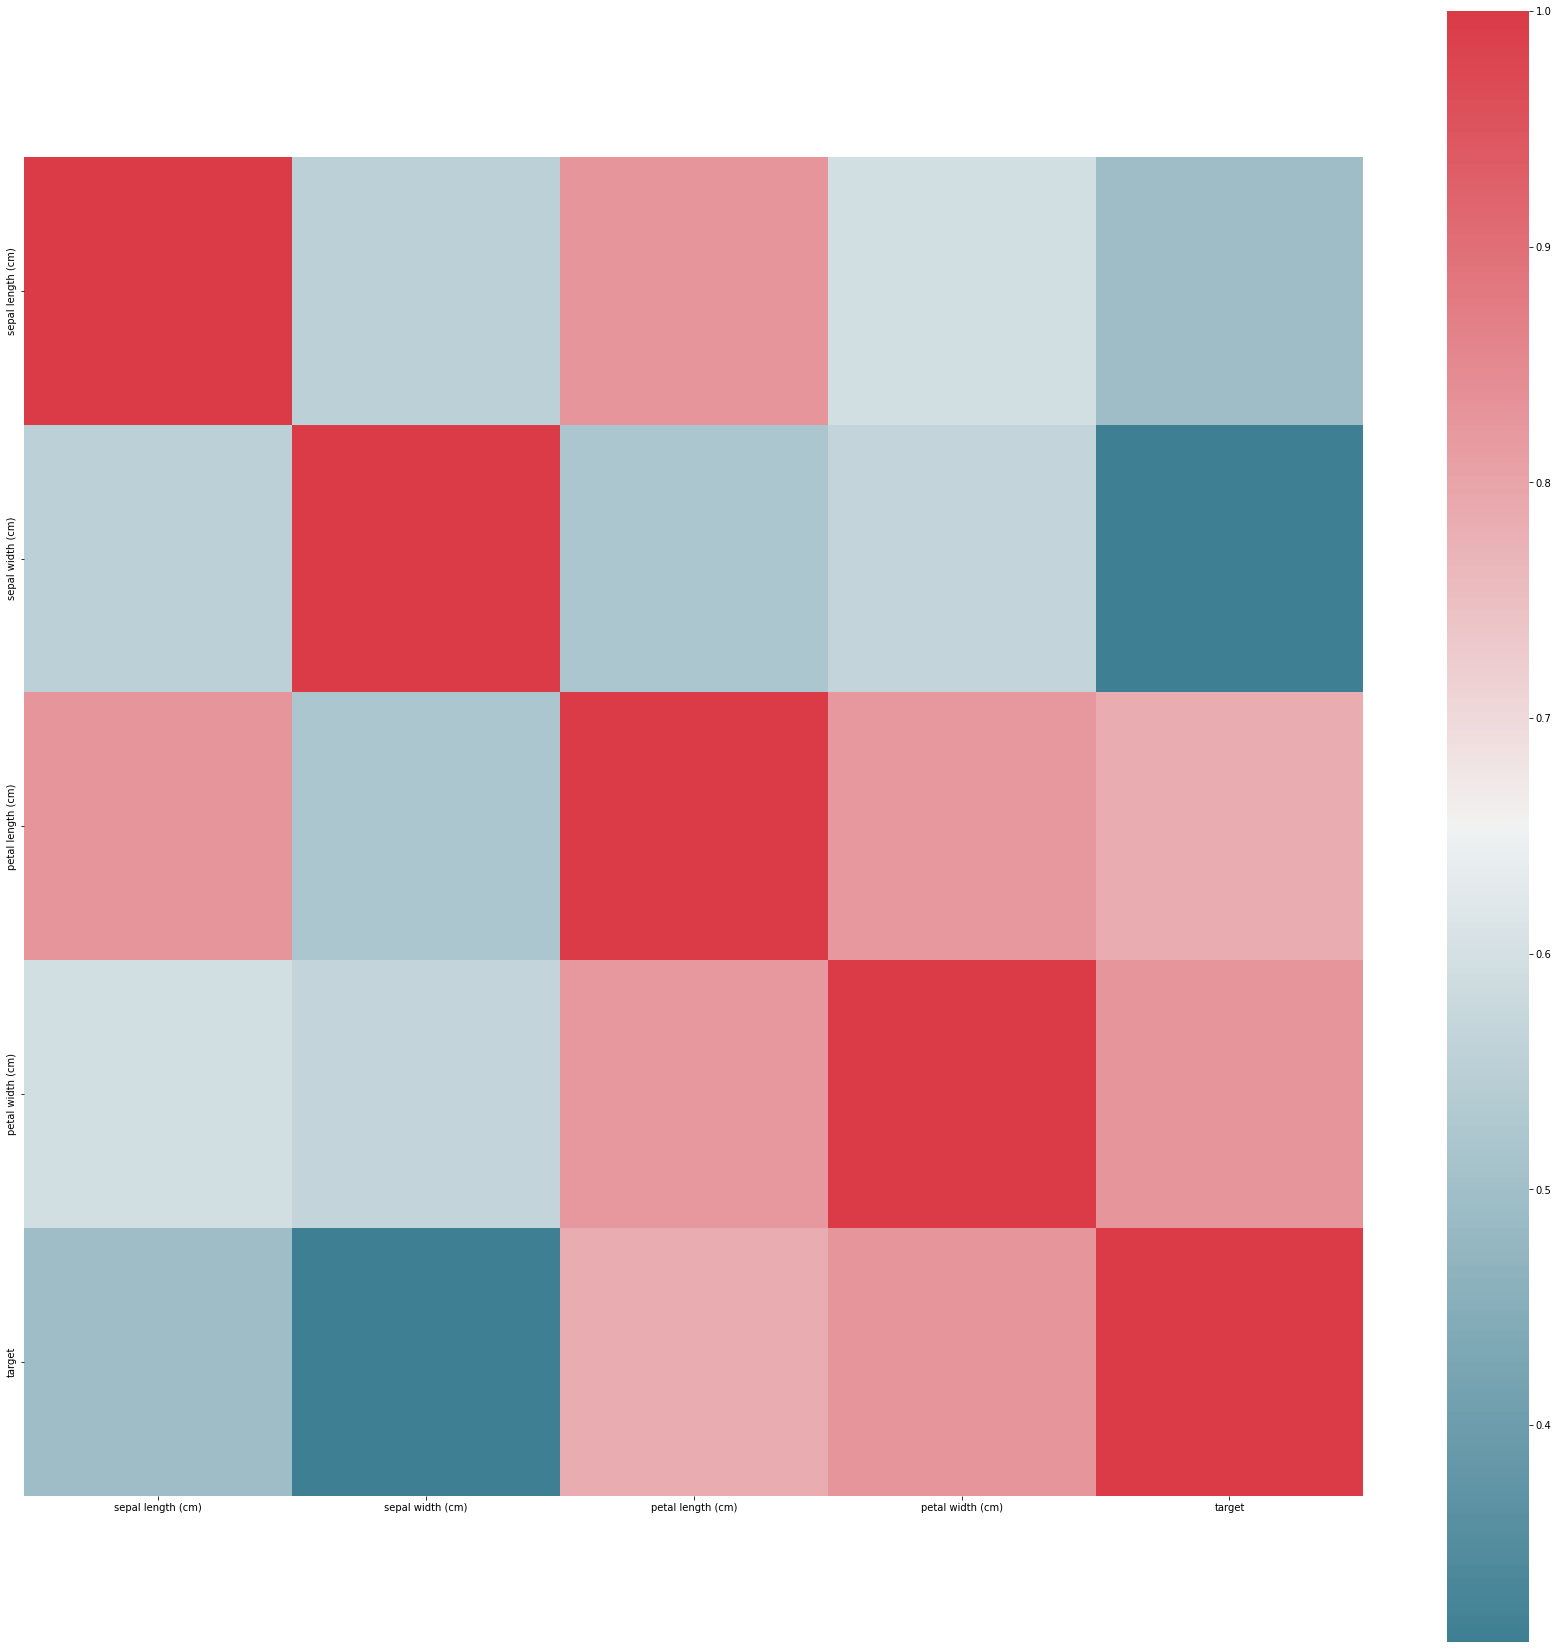

In [ ]:
f, ax = plt.subplots(figsize=(30,30))
corr = df_filtered.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

Хорошо видно, что между классом и признаками есть заметная корреляция
Подготовим данные для обучения и проверки

In [ ]:
X = df_filtered[dataset['feature_names']]
y = df_filtered['target']

In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Для нашей модели выберем следующие гиперпараметры:

Batch Size: 30

epochs: 1000

leraning rate: 0.01


In [ ]:
custom_model = CustomLogisticRegression(bs=30, epochs=1000, lr=0.01)

Обучим модель с замером скорости обучения

In [ ]:
%%timeit
custom_model.fit(X_train, y_train)

746 ms ± 26.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Точность модели

In [ ]:
custom_model.score(X_train, y_train)

0.9

In [ ]:
custom_model.score(X_test, y_test)

0.9

Сравним нашу модель с LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

Для предобработки будем в пайплайне использовать StandardScaler, по аналогии с нашей моделью

In [ ]:
pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

In [ ]:
%%timeit
pipeline.fit(X_train, y_train)

4.05 ms ± 215 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
pipeline.score(X_train, y_train)

0.975

In [ ]:
pipeline.score(X_test, y_test)

0.9

Сравним нашу модель с моделью LogisticRegression обученой с помощью SGD (аналогично нашей модели)

In [ ]:
from sklearn.linear_model import SGDClassifier

Гиперпараметры выбираем аналогично нашей модели

In [ ]:
pipeline = make_pipeline(StandardScaler(), SGDClassifier(loss='log', max_iter=1000, learning_rate='constant',
                                                        eta0=0.01))

In [ ]:
%%timeit
pipeline.fit(X_train, y_train)

2.37 ms ± 66.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
pipeline.score(X_train, y_train)

0.975

In [ ]:
pipeline.score(X_test, y_test)

0.9

### Выводы
Видно, что наша модель работает почти в 20 раз медленней библиотечной LogisticRegression и почти в 40 раз медленее SGDClassifier.

Точность на тренировочных данных библиотечная модель дает выше, на тестовых результат идентичен.

| model                               | train score | test score | time              |
|-------------------------------------|-------------|------------|-------------------|
| Custom LogisticRegression           | 0.9         | 0.9        | 746 ms ± 26.6 ms  |
| LogisticRegression + StandardSclaer | 0.975       | 0.9        | 4.05 ms ± 215 µs  |
| SGDClassifier + StandardScaler      | 0.975       | 0.9        | 2.37 ms ± 66.1 µs |
